#Q8

In [1]:
!git clone https://github.com/zahraDehghanian97/Histogram_Equalization.git

Cloning into 'Histogram_Equalization'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 23 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), 6.79 MiB | 6.39 MiB/s, done.


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Read the image
img = cv2.imread('/content/Histogram_Equalization/images/6.jpg', cv2.IMREAD_GRAYSCALE)

In [ ]:
# Contrast Stretching function
def contrast_stretching(img):
    min_val = np.min(img)
    max_val = np.max(img)
    out = np.uint8((img - min_val) * 255.0 / (max_val - min_val))
    return out

# Histogram Equalization function
def histogram_equalization(img):
    hist, bins = np.histogram(img.ravel(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    cdf_m = np.ma.masked_equal(cdf_normalized, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')
    out = cdf[img]
    return out

In [ ]:
# Apply Contrast Stretching
img_cs = contrast_stretching(img)

# Apply Histogram Equalization
img_he = histogram_equalization(img)

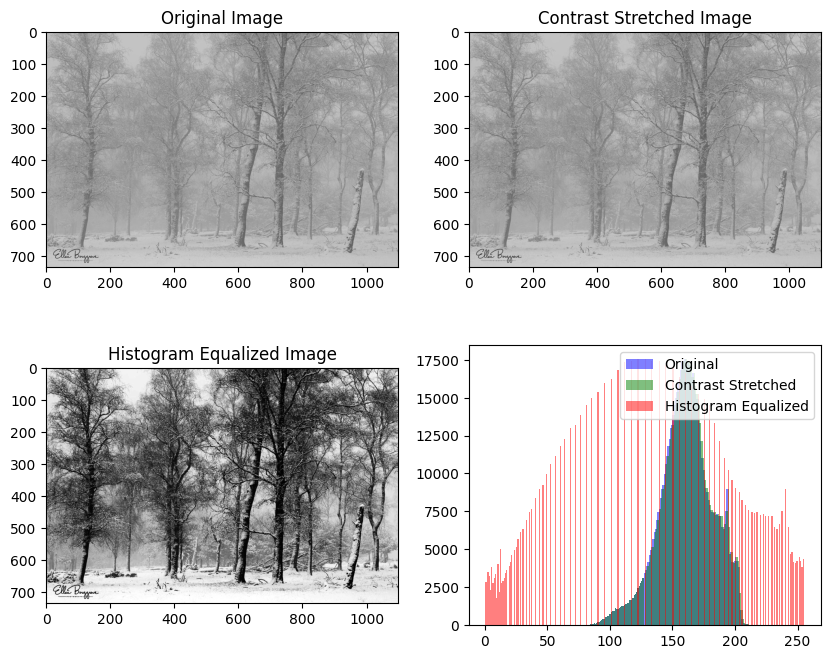

In [2]:
# Plot the original, Contrast Stretched and Histogram Equalized images
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(2, 2, 2)
plt.imshow(img_cs, cmap='gray')
plt.title('Contrast Stretched Image')
plt.subplot(2, 2, 3)
plt.imshow(img_he, cmap='gray')
plt.title('Histogram Equalized Image')

# Plot the histograms
plt.subplot(2, 2, 4)
plt.hist(img.ravel(), 256, [0, 256], color='blue', alpha=0.5, label='Original')
plt.hist(img_cs.ravel(), 256, [0, 256], color='green', alpha=0.5, label='Contrast Stretched')
plt.hist(img_he.ravel(), 256, [0, 256], color='red', alpha=0.5, label='Histogram Equalized')
plt.legend(loc='upper right')
plt.show()

It looks like Histogram Equalization performs totally better than Contrast Streching because it could remove rare outlier pixel and make a more natural and high contrast with good looking image

#Q9

In [ ]:
# Load images
images = [cv2.imread(f'/content/Histogram_Equalization/images/{i}.jpg') for i in range(6)]

In [ ]:
# merge same color channels into 3 images
get_all_channels = lambda imgs, chn: np.stack([img[:, :, chn] for img in imgs])
images_b = get_all_channels(images, 0)
images_g = get_all_channels(images, 1)
images_r = get_all_channels(images, 2)

In [ ]:
# use an linear transformation to make the range of image into[0, 255]
def fix_numbers(channel):
    channel = channel.astype('float128')
    min_v = np.min(channel)
    max_v = np.max(channel)
    channel = (channel - min_v) * 256 // (max_v - min_v)
    return channel.astype('uint8')

def pca_fit_transform(X, n_components):
    mean = np.average(X, axis=1).reshape(-1, 1)
    std_dev = np.std(X, axis=1).reshape(-1, 1)
    X = (X - mean) / std_dev
    covariance_matrix = np.cov(X.T)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    projection_matrix = (eigen_vectors.T[:][:n_components]).T
    return_value = X @ projection_matrix
    return_value = (return_value * std_dev) + mean
    return return_value
    
# input must be channel first - output will be channel first
def use_pca_for_image(img_inp, n_components):
    img_channel_first = img_inp # the input image is already channel first
    orig_shape = img_channel_first.shape # store old size
    img_as_row = img_channel_first.reshape(orig_shape[0], -1).transpose() # make image into (n_samples, n_features) style
    new_img_as_row = pca_fit_transform(img_as_row, n_components)
    new_img = new_img_as_row.transpose().reshape(n_components , orig_shape[1], orig_shape[2])
    for idx, channel in enumerate(new_img):
        new_img[idx] = fix_numbers(channel)
    
    return new_img.astype('uint8')#.transpose([1, 2, 0])

In [ ]:
# calculate best mapping of each channel using pca

chn_b = use_pca_for_image(images_b, 1)[0]
chn_g = use_pca_for_image(images_g, 1)[0]
chn_r = use_pca_for_image(images_r, 1)[0]

In [ ]:
# join all channels to create a color image
merged_channels = np.stack([chn_r, chn_g, chn_b], axis=-1)

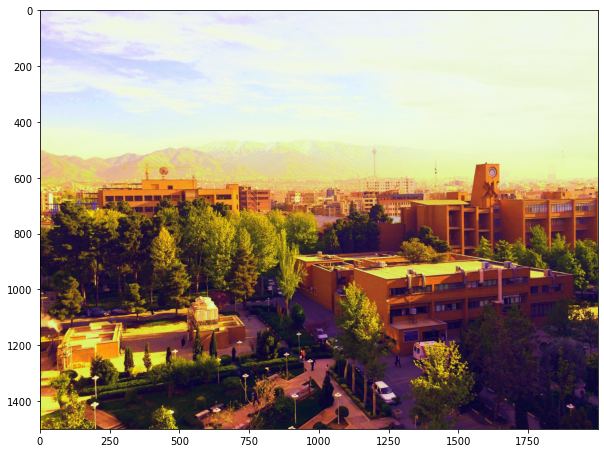

In [ ]:
#plot result
plt.figure(figsize=(10, 10))
plt.imshow(merged_channels)